## <p style="padding:15px; background-color:#b48dda; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px; margin-bottom: -30px;">Setup</p>

In [1]:
import os

# no internet access D:

# if not os.path.isdir('src'):
#     !git init .
#     !git remote add origin https://github.com/Manuel-Materazzo/Problematic-Internet-Use-Prediction.git

# print('Pulling...')
# !git pull origin master -q

# print('Installing dependencies...')
# !pip install -r /kaggle/working/src/requirements.txt -q

# copy offline source
!cp -r /kaggle/input/boost-utils-source/BoostUtils-1.2.0/BoostUtils-1.2.0/* /kaggle/working

# install offline dependencies
print('Installing dependencies...')
!pip install --no-index --find-links /kaggle/input/boostutils-v1-2-0-dependencies -r /kaggle/working/src/requirements.txt -q

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

import re
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from src.pipelines.dt_pipeline import DTPipeline

from src.enums.accuracy_metric import AccuracyMetric
from src.enums.optimization_direction import OptimizationDirection

from src.models.catboost_regressor import CatBoostRegressorWrapper
from src.models.hgb_regressor import HGBRegressorWrapper
from src.models.lgbm_regressor import LGBMRegressorWrapper
from src.models.xgb_regressor import XGBRegressorWrapper
from src.models.tabnet_regressor import TabNetRegressorWrapper

from src.models.catboost_classifier import CatBoostClassifierWrapper
from src.models.hgb_classifier import HGBClassifierWrapper
from src.models.lgbm_classifier import LGBMClassifierWrapper
from src.models.xgb_classifier import XGBClassifierWrapper
from src.models.tabnet_classifier import TabNetClassifierWrapper

from src.trainers.simple_trainer import SimpleTrainer
from src.trainers.accurate_cross_trainer import AccurateCrossTrainer
from src.trainers.cached_accurate_cross_trainer import CachedAccurateCrossTrainer

from src.hyperparameter_optimizers.custom_grid_optimizer import CustomGridOptimizer
from src.hyperparameter_optimizers.default_grid_optimizer import DefaultGridOptimizer
from src.hyperparameter_optimizers.hyperopt_bayesian_optimizer import HyperoptBayesianOptimizer
from src.hyperparameter_optimizers.optuna_optimizer import OptunaOptimizer

from src.ensembles.weighted_ensemble import WeightedEnsemble
from src.ensembles.stacked_ensemble import StackedEnsemble

pd.set_option('display.max_columns', None)

def load_data():
    # Load the data
    file_path = '/kaggle/input/child-mind-institute-problematic-internet-use/train.csv'
    data = pd.read_csv(file_path, index_col='id')
    
    # Remove rows with missing target, separate target from predictors
    data.dropna(axis=0, subset=['sii'], inplace=True)
    y = data['sii']
    X = data.drop(['sii'], axis=1)

    # standardize column names
    data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))
    X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))
    return X, y, data

print('Loading data...')
X, y, raw_data = load_data()
print("✅ Done.")

Installing dependencies...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.15.2 requires botocore<1.35.37,>=1.35.16, but you have botocore 1.35.84 which is incompatible.
albucore 0.0.20 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albumentations 1.4.21 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.1.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 18.1.0 which is incompatible.
bayesian-optimization 2.0.0 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
beatrix-jupyterlab 2024.66.154055 requires jupyterlab~=3.6.0, but you have jupyterlab 4.3.1 which is inc

In [2]:
pciat_indexes_columns = [f'PCIAT_PCIAT_{i+1:02d}' for i in range(20)]

# Recalculate sii
def recalculate_sii(row):
    if pd.isna(row['PCIAT_PCIAT_Total']):
        return np.nan
    max_possible = row['PCIAT_PCIAT_Total'] + row[pciat_indexes_columns].isna().sum() * 5
    if row['PCIAT_PCIAT_Total'] <= 30 and max_possible <= 30:
        return 0
    elif 31 <= row['PCIAT_PCIAT_Total'] <= 49 and max_possible <= 49:
        return 1
    elif 50 <= row['PCIAT_PCIAT_Total'] <= 79 and max_possible <= 79:
        return 2
    elif row['PCIAT_PCIAT_Total'] >= 80 and max_possible >= 80:
        return 3
    return np.nan

#y = raw_data.apply(recalculate_sii, axis=1)

## <p style="padding:15px; background-color:#b48dda; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px; margin-bottom: -30px; margin-top: 50px;">Data Exploration</p>

In [3]:
raw_data.head()

,Basic_Demos_Enroll_Season,Basic_Demos_Age,Basic_Demos_Sex,CGAS_Season,CGAS_CGAS_Score,Physical_Season,Physical_BMI,Physical_Height,Physical_Weight,Physical_Waist_Circumference,Physical_Diastolic_BP,Physical_HeartRate,Physical_Systolic_BP,Fitness_Endurance_Season,Fitness_Endurance_Max_Stage,Fitness_Endurance_Time_Mins,Fitness_Endurance_Time_Sec,FGC_Season,FGC_FGC_CU,FGC_FGC_CU_Zone,FGC_FGC_GSND,FGC_FGC_GSND_Zone,FGC_FGC_GSD,FGC_FGC_GSD_Zone,FGC_FGC_PU,FGC_FGC_PU_Zone,FGC_FGC_SRL,FGC_FGC_SRL_Zone,FGC_FGC_SRR,FGC_FGC_SRR_Zone,FGC_FGC_TL,FGC_FGC_TL_Zone,BIA_Season,BIA_BIA_Activity_Level_num,BIA_BIA_BMC,BIA_BIA_BMI,BIA_BIA_BMR,BIA_BIA_DEE,BIA_BIA_ECW,BIA_BIA_FFM,BIA_BIA_FFMI,BIA_BIA_FMI,BIA_BIA_Fat,BIA_BIA_Frame_num,BIA_BIA_ICW,BIA_BIA_LDM,BIA_BIA_LST,BIA_BIA_SMM,BIA_BIA_TBW,PAQ_A_Season,PAQ_A_PAQ_A_Total,PAQ_C_Season,PAQ_C_PAQ_C_Total,PCIAT_Season,PCIAT_PCIAT_01,PCIAT_PCIAT_02,PCIAT_PCIAT_03,PCIAT_PCIAT_04,PCIAT_PCIAT_05,PCIAT_PCIAT_06,PCIAT_PCIAT_07,PCIAT_PCIAT_08,PCIAT_PCIAT_09,PCIAT_PCIAT_10,PCIAT_PCIAT_11,PCIAT_PCIAT_12,PCIAT_PCIAT_13,PCIAT_PCIAT_14,PCIAT_PCIAT_15,PCIAT_PCIAT_16,PCIAT_PCIAT_17,PCIAT_PCIAT_18,PCIAT_PCIAT_19,PCIAT_PCIAT_20,PCIAT_PCIAT_Total,SDS_Season,SDS_SDS_Total_Raw,SDS_SDS_Total_T,PreInt_EduHx_Season,PreInt_EduHx_computerinternet_hoursday,sii
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,NaN,60.0,73.0,102.0,NaN,NaN,NaN,NaN,Summer,12.0,0.0,16.5,2.0,17.9,2.0,6.0,0.0,10.0,1.0,11.0,1.0,8.0,0.0,Summer,2.0,4.33036,30.1865,1330.970,1996.45,30.21240,84.0285,16.6877,13.49880,67.97150,2.0,32.9141,20.90200,79.6982,35.3804,63.1265,NaN,NaN,Spring,4.110,Summer,3.0,3.0,3.0,0.0,2.0,1.0,0.0,2.0,2.0,1.0,0.0,1.0,3.0,3.0,2.0,1.0,3.0,1.0,2.0,1.0,34.0,Summer,40.0,56.0,Spring,0.0,1.0


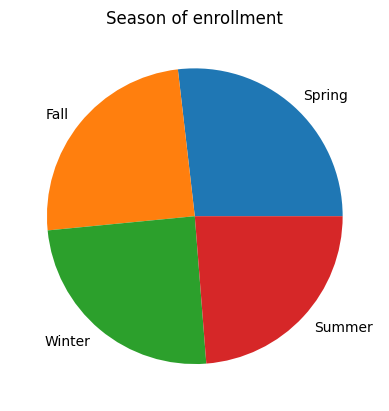

In [4]:
season_counts = raw_data['Basic_Demos_Enroll_Season'].value_counts()
season_counts
plt.pie(season_counts, labels=season_counts.index)
plt.title('Season of enrollment')
plt.show()

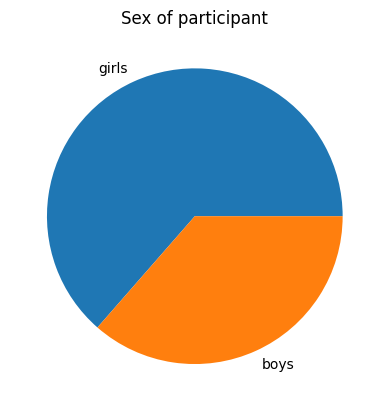

In [5]:
sex_counts = raw_data['Basic_Demos_Sex'].value_counts()
plt.pie(sex_counts, labels=['girls', 'boys'])
plt.title('Sex of participant')
plt.show()

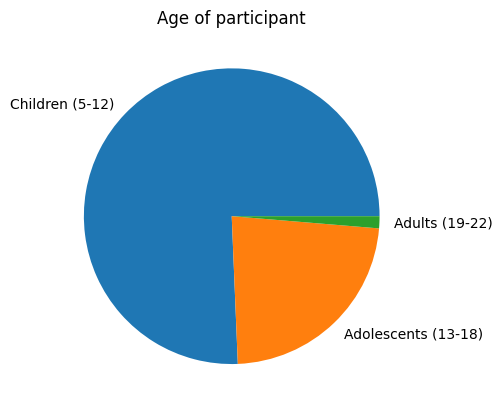

In [6]:
age_distribution = pd.cut(
    raw_data['Basic_Demos_Age'],
    bins=[4, 12, 18, 22],
    labels=['Children (5-12)', 'Adolescents (13-18)', 'Adults (19-22)']
)

age_counts = age_distribution.value_counts()
plt.pie(age_counts, labels=['Children (5-12)', 'Adolescents (13-18)', 'Adults (19-22)'])
plt.title('Age of participant')
plt.show()

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; background-color: #f6f5f5; text-align:left">
    
##### Initial observations:
- enrollment distribution is even, we have prevalent girl data, and the participants are mostly childrens.
- there are several season categorical columns, namely: Basic_Demos_Enroll_Season, CGAS_Season, Physical_Season, Fitness_Endurance_Season, FGC_Season, BIA_Season, PAQ_A_Season, PAQ_C_Season, PCIAT_Season, SDS_Season and PreInt_EduHx_Season.
- there are other categorical columns, but they are already encoded.

In [7]:
raw_data.columns

Index(['Basic_Demos_Enroll_Season', 'Basic_Demos_Age', 'Basic_Demos_Sex',
       'CGAS_Season', 'CGAS_CGAS_Score', 'Physical_Season', 'Physical_BMI',
       'Physical_Height', 'Physical_Weight', 'Physical_Waist_Circumference',
       'Physical_Diastolic_BP', 'Physical_HeartRate', 'Physical_Systolic_BP',
       'Fitness_Endurance_Season', 'Fitness_Endurance_Max_Stage',
       'Fitness_Endurance_Time_Mins', 'Fitness_Endurance_Time_Sec',
       'FGC_Season', 'FGC_FGC_CU', 'FGC_FGC_CU_Zone', 'FGC_FGC_GSND',
       'FGC_FGC_GSND_Zone', 'FGC_FGC_GSD', 'FGC_FGC_GSD_Zone', 'FGC_FGC_PU',
       'FGC_FGC_PU_Zone', 'FGC_FGC_SRL', 'FGC_FGC_SRL_Zone', 'FGC_FGC_SRR',
       'FGC_FGC_SRR_Zone', 'FGC_FGC_TL', 'FGC_FGC_TL_Zone', 'BIA_Season',
       'BIA_BIA_Activity_Level_num', 'BIA_BIA_BMC', 'BIA_BIA_BMI',
       'BIA_BIA_BMR', 'BIA_BIA_DEE', 'BIA_BIA_ECW', 'BIA_BIA_FFM',
       'BIA_BIA_FFMI', 'BIA_BIA_FMI', 'BIA_BIA_Fat', 'BIA_BIA_Frame_num',
       'BIA_BIA_ICW', 'BIA_BIA_LDM', 'BIA_BIA_LST', 'BIA

In [8]:
print('number of rows: ', len(raw_data))
print(f"There are {sum(X.duplicated())} duplicated rows in the train data frame.")

rows_with_missing_target = raw_data.loc[raw_data['sii'].isnull()]
print(f"There are {len(rows_with_missing_target)} rows with missing target.")

print()
print('total columns: ', len(raw_data.columns.values))
print()

features_with_missing_values = [col for col in raw_data.columns if raw_data[col].isnull().any()]
print('number of columns with missing values: ', len(features_with_missing_values))
print(features_with_missing_values)
print()

categorical_cols = [cname for cname in raw_data.columns if raw_data[cname].dtype == "object"]
print('number of categorical columns: ', len(categorical_cols))
print(categorical_cols)

number of rows:  2736
There are 0 duplicated rows in the train data frame.
There are 0 rows with missing target.

total columns:  81

number of columns with missing values:  75
['CGAS_Season', 'CGAS_CGAS_Score', 'Physical_Season', 'Physical_BMI', 'Physical_Height', 'Physical_Weight', 'Physical_Waist_Circumference', 'Physical_Diastolic_BP', 'Physical_HeartRate', 'Physical_Systolic_BP', 'Fitness_Endurance_Season', 'Fitness_Endurance_Max_Stage', 'Fitness_Endurance_Time_Mins', 'Fitness_Endurance_Time_Sec', 'FGC_Season', 'FGC_FGC_CU', 'FGC_FGC_CU_Zone', 'FGC_FGC_GSND', 'FGC_FGC_GSND_Zone', 'FGC_FGC_GSD', 'FGC_FGC_GSD_Zone', 'FGC_FGC_PU', 'FGC_FGC_PU_Zone', 'FGC_FGC_SRL', 'FGC_FGC_SRL_Zone', 'FGC_FGC_SRR', 'FGC_FGC_SRR_Zone', 'FGC_FGC_TL', 'FGC_FGC_TL_Zone', 'BIA_Season', 'BIA_BIA_Activity_Level_num', 'BIA_BIA_BMC', 'BIA_BIA_BMI', 'BIA_BIA_BMR', 'BIA_BIA_DEE', 'BIA_BIA_ECW', 'BIA_BIA_FFM', 'BIA_BIA_FFMI', 'BIA_BIA_FMI', 'BIA_BIA_Fat', 'BIA_BIA_Frame_num', 'BIA_BIA_ICW', 'BIA_BIA_LDM', 'BIA_B

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; background-color: #f6f5f5; text-align:left">

There is plenty of missing data. The only categorical feature left are seasons.

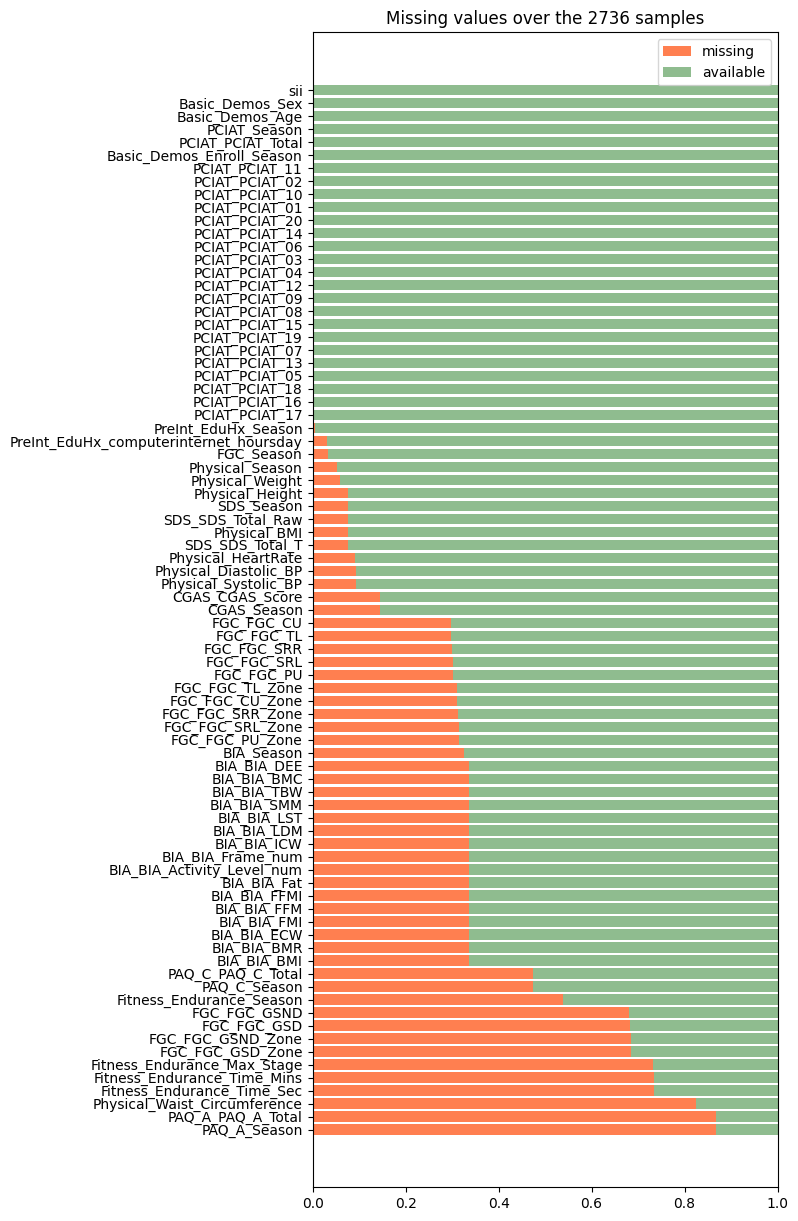

In [9]:
# Calculate missing values and null ratio
missing_count = (
    raw_data.isnull().sum()
    .reset_index()
    .rename(columns={'index': 'feature', 0: 'null_count'})
    .sort_values('null_count', ascending=False)
)
missing_count['null_ratio'] = missing_count['null_count'] / len(raw_data)

# Plotting
plt.figure(figsize=(6, 15))
plt.title(f'Missing values over the {len(raw_data)} samples')
plt.barh(np.arange(len(missing_count)), missing_count['null_ratio'], color='coral', label='missing')
plt.barh(np.arange(len(missing_count)), 
         1 - missing_count['null_ratio'],
         left=missing_count['null_ratio'],
         color='darkseagreen', label='available')
plt.yticks(np.arange(len(missing_count)), missing_count['feature'])
plt.xlim(0, 1)
plt.legend()
plt.show()

In [10]:
PAQ_A_PAQ_A_Total = len(raw_data.loc[raw_data['PAQ_A_Season'].isnull() & (raw_data['PAQ_A_PAQ_A_Total'].notnull())])
print('number of paq_a discrepancies: ', PAQ_A_PAQ_A_Total)

FGC_FGC_CU = len(raw_data.loc[raw_data['FGC_Season'].isnull() & (raw_data['FGC_FGC_CU'].notnull())])
FGC_FGC_CU_Zone = len(raw_data.loc[raw_data['FGC_Season'].isnull() & (raw_data['FGC_FGC_CU_Zone'].notnull())])
FGC_FGC_GSND = len(raw_data.loc[raw_data['FGC_Season'].isnull() & (raw_data['FGC_FGC_GSND'].notnull())])
FGC_FGC_GSND_Zone = len(raw_data.loc[raw_data['FGC_Season'].isnull() & (raw_data['FGC_FGC_GSND_Zone'].notnull())])
print(f'number of fgc discrepancies: {FGC_FGC_CU},{FGC_FGC_CU_Zone},{FGC_FGC_GSND},{FGC_FGC_GSND_Zone}')

Fitness_Endurance_Max_Stage = len(raw_data.loc[raw_data['Fitness_Endurance_Season'].isnull() & (raw_data['Fitness_Endurance_Max_Stage'].notnull())])
Fitness_Endurance_Time_Mins = len(raw_data.loc[raw_data['Fitness_Endurance_Season'].isnull() & (raw_data['Fitness_Endurance_Time_Mins'].notnull())])
Fitness_Endurance_Time_Sec = len(raw_data.loc[raw_data['Fitness_Endurance_Season'].isnull() & (raw_data['Fitness_Endurance_Time_Sec'].notnull())])
print(f'number of Fitness_Endurance discrepancies: {Fitness_Endurance_Max_Stage},{Fitness_Endurance_Time_Mins},{Fitness_Endurance_Time_Sec}')

number of paq_a discrepancies:  0
number of fgc discrepancies: 0,0,0,0
number of Fitness_Endurance discrepancies: 0,0,0


<div style="border-radius:12px; border:#b48dda solid; padding: 15px; background-color: #f6f5f5; text-align:left">

Missing data over the standard "acceptable" rate comes from:
- Physical Activity Questionnaire
- FitnessGram Child
- FitnessGram Vitals and Treadmill
Also, "Waist circumference" was measured way less than other Physical Measures.<br>

Missing seasons always coincide with missing season data.

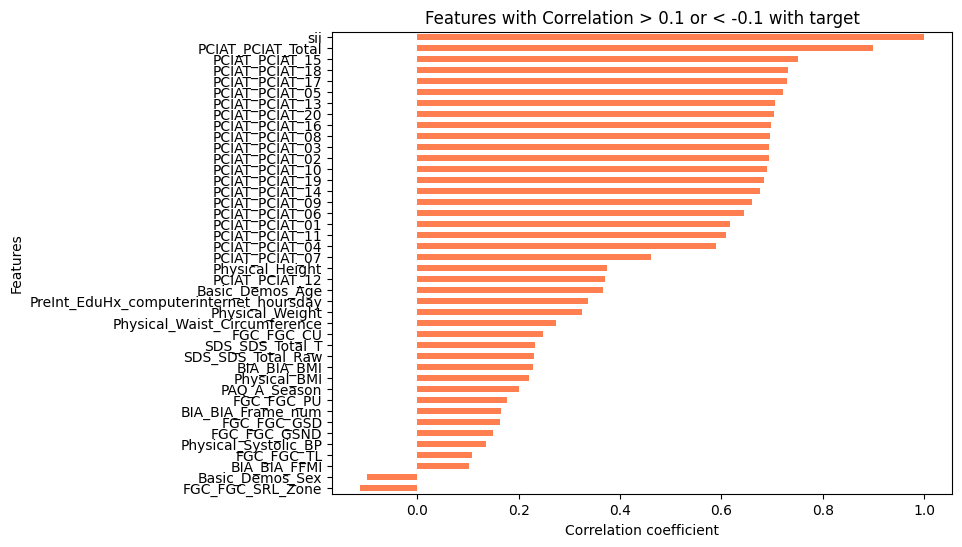

In [11]:
correlation_data = raw_data.copy()
seasons_dictionary = {'Spring': 0, 'Summer': 1, 'Fall': 2, 'Winter': 3}

# encode seasons
for col in correlation_data.columns:
    if '_Season' in col:
        # Assign values based on the season dictionary and set -1 for empty values
        correlation_data[col] = correlation_data[col].apply(lambda x: seasons_dictionary.get(x, -1) if x != '' else -1)

sii_corr = correlation_data.corr()['sii']
filtered_corr = sii_corr[(sii_corr > 0.1) | (sii_corr < -0.1)]

plt.figure(figsize=(8, 6))
filtered_corr.sort_values().plot(kind='barh', color='coral')
plt.title('Features with Correlation > 0.1 or < -0.1 with target')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.show()

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; background-color: #f6f5f5; text-align:left">

As expected, the PCIAT test indexes are a strong correlator of the sii. To get a somewhat meaningful model, we must remove them.

In [12]:
# Get pciat columns name
pciat_columns = [f'PCIAT_PCIAT_{i+1:02d}' for i in range(20)]

# check if the total is always the sum of non NaN values
recalc_total_score = raw_data[pciat_columns].sum(axis=1, skipna=True)
is_sum_of_non_na = (recalc_total_score == raw_data['PCIAT_PCIAT_Total']).all()
print(f'The PCIAT_PCIAT_Total field consists of the sum on non nan PCIAT scores: {is_sum_of_non_na}')

pciat_columns.append('sii')

# show some data, highligting NaN values
train_with_sii = raw_data[raw_data['sii'].notna()][pciat_columns]
train_with_sii[train_with_sii.isna().any(axis=1)].head().style.map(
    lambda x: 'background-color: #FFC0CB' if pd.isna(x) else ''
)

The PCIAT_PCIAT_Total field consists of the sum on non nan PCIAT scores: True


,PCIAT_PCIAT_01,PCIAT_PCIAT_02,PCIAT_PCIAT_03,PCIAT_PCIAT_04,PCIAT_PCIAT_05,PCIAT_PCIAT_06,PCIAT_PCIAT_07,PCIAT_PCIAT_08,PCIAT_PCIAT_09,PCIAT_PCIAT_10,PCIAT_PCIAT_11,PCIAT_PCIAT_12,PCIAT_PCIAT_13,PCIAT_PCIAT_14,PCIAT_PCIAT_15,PCIAT_PCIAT_16,PCIAT_PCIAT_17,PCIAT_PCIAT_18,PCIAT_PCIAT_19,PCIAT_PCIAT_20,sii
id,,,,,,,,,,,,,,,,,,,,,
011e71c3,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,nan,2.000000,0.000000
053d7d31,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000
05bc318e,5.000000,2.000000,4.000000,2.000000,nan,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,1.000000
08159c5e,1.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,nan,0.000000,2.000000,0.000000,0.000000
082df556,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,1.000000,0.000000


<div style="border-radius:12px; border:#b48dda solid; padding: 15px; background-color: #f6f5f5; text-align:left">

Some of the Parent-Child Internet Addiction Test questions are not answered.<br>
The SII score is derived from the the sum of the non-NA values, leading to potentially invalid SII values.<br>
On the second row, PCIAT-PCIAT_Total and sii appears to have been filled in by mistake, as there are no test questions answered at all.

/tmp/ipykernel_17/2728788023.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sii', y='count', data=sii_counts, palette='Blues_d', ax=axes[0])


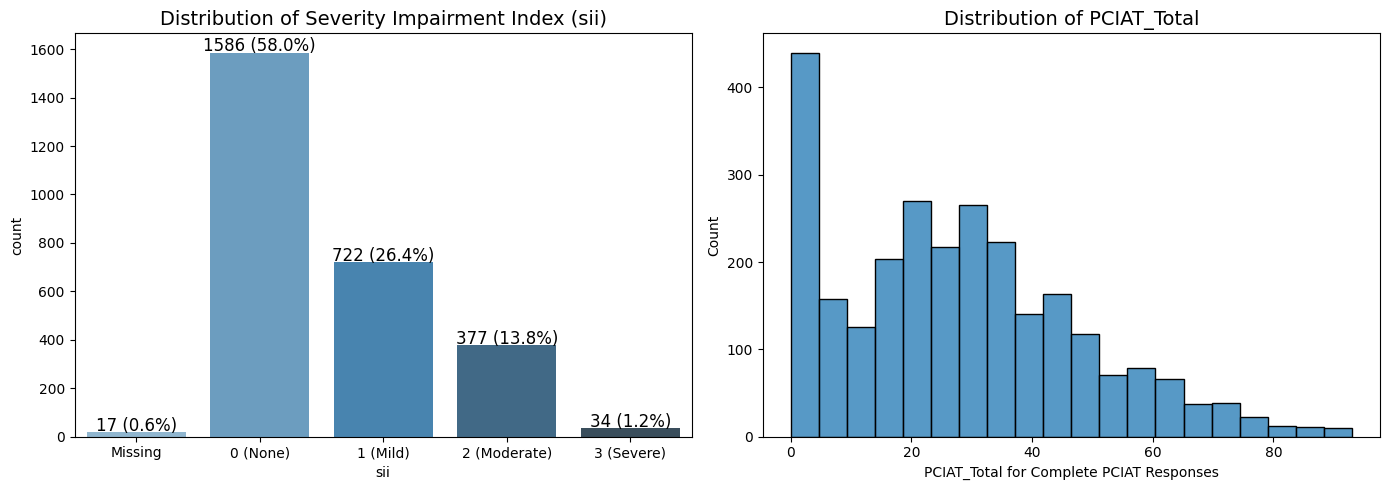

In [13]:
# recalculate sii
target_analysis_data = raw_data.copy()
target_analysis_data['sii'] = target_analysis_data.apply(recalculate_sii, axis=1)

# calculate total
target_analysis_data['complete_resp_total'] = target_analysis_data['PCIAT_PCIAT_Total'].where(
    target_analysis_data[pciat_columns].notna().all(axis=1), np.nan
)

# label mappings
sii_map = {0: '0 (None)', 1: '1 (Mild)', 2: '2 (Moderate)', 3: '3 (Severe)'}
target_analysis_data['sii'] = target_analysis_data['sii'].map(sii_map).fillna('Missing')

sii_order = ['Missing', '0 (None)', '1 (Mild)', '2 (Moderate)', '3 (Severe)']
target_analysis_data['sii'] = pd.Categorical(target_analysis_data['sii'], categories=sii_order, ordered=True)

# counts
sii_counts = target_analysis_data['sii'].value_counts().reset_index()
total = sii_counts['count'].sum()
sii_counts['percentage'] = (sii_counts['count'] / total) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SII
sns.barplot(x='sii', y='count', data=sii_counts, palette='Blues_d', ax=axes[0])
axes[0].set_title('Distribution of Severity Impairment Index (sii)', fontsize=14)
for p in axes[0].patches:
    height = p.get_height()
    percentage = sii_counts.loc[sii_counts['count'] == height, 'percentage'].values[0]
    axes[0].text(
        p.get_x() + p.get_width() / 2,
        height + 5, f'{int(height)} ({percentage:.1f}%)',
        ha="center", fontsize=12
    )

# PCIAT_Total for complete responses
sns.histplot(target_analysis_data['complete_resp_total'].dropna(), bins=20, ax=axes[1])
axes[1].set_title('Distribution of PCIAT_Total', fontsize=14)
axes[1].set_xlabel('PCIAT_Total for Complete PCIAT Responses')

plt.tight_layout()
plt.show()


<div style="border-radius:12px; border:#b48dda solid; padding: 15px; background-color: #f6f5f5; text-align:left">

apparently, only the 15% of the partecipants manifested moderate to severe internet use impairment.

## <p style="padding:15px; background-color:#b48dda; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px; margin-bottom: -30px; margin-top: 50px;">Feature Engineering</p>

In [14]:
seasons_dictionary = {'Spring': 0, 'Summer': 1, 'Fall': 2, 'Winter': 3}
half_missing = [val for val in X.columns[(X.isnull().sum() * 100 / len(X)) > 60]]
null_filling_cols = [
    'Basic_Demos_Sex', 'FGC_FGC_CU', 'FGC_FGC_CU_Zone',
    'FGC_FGC_GSD_Zone', 'FGC_FGC_PU_Zone', 'FGC_FGC_SRL_Zone',
    'FGC_FGC_GSND_Zone', 'FGC_FGC_SRR_Zone', 'FGC_FGC_TL_Zone'
]

def encode_and_fill(X):
    # encode seasons
    for col in X.columns:
        if '_Season' in col:
            # Assign values based on the season dictionary and set -1 for empty values
            X[col] = X[col].apply(lambda x: seasons_dictionary.get(x, -1) if x != '' else -1)
            
    for col in null_filling_cols:
        # Explicitely set -1 to mark a missing value
        X[col] = X[col].fillna(-1)

def select_columns(X):
    for column in X.columns:
        # drop PCIAT columns, the test was almost always administered AFTER the diagnosis and it's not on the test set
        # i'm not using pciat_indexes_columns, because could be other PCIAT  (not indexes) on the test set
        if 'PCIAT_' in column:
            X.drop([column], axis=1, inplace=True)
            
        #elif column in half_missing:
        # drop features with over 50% of missing values
            #X.drop([column], axis=1, inplace=True)

def feature_engineering(df):
    df['BMI_Age'] = df['Physical_BMI'] * df['Basic_Demos_Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx_computerinternet_hoursday'] * df['Basic_Demos_Age']
    df['BMI_Internet_Hours'] = df['Physical_BMI'] * df['PreInt_EduHx_computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA_BIA_Fat'] / df['BIA_BIA_BMI']
    df['FFMI_BFP'] = df['BIA_BIA_FFMI'] / df['BIA_BIA_Fat']
    df['FMI_BFP'] = df['BIA_BIA_FMI'] / df['BIA_BIA_Fat']
    df['LST_TBW'] = df['BIA_BIA_LST'] / df['BIA_BIA_TBW']
    df['BFP_BMR'] = df['BIA_BIA_Fat'] * df['BIA_BIA_BMR']
    df['BFP_DEE'] = df['BIA_BIA_Fat'] * df['BIA_BIA_DEE']
    df['BMR_Weight'] = df['BIA_BIA_BMR'] / df['Physical_Weight']
    df['DEE_Weight'] = df['BIA_BIA_DEE'] / df['Physical_Weight']
    df['SMM_Height'] = df['BIA_BIA_SMM'] / df['Physical_Height']
    df['Muscle_to_Fat'] = df['BIA_BIA_SMM'] / df['BIA_BIA_FMI']
    df['Hydration_Status'] = df['BIA_BIA_TBW'] / df['Physical_Weight']
    df['ICW_TBW'] = df['BIA_BIA_ICW'] / df['BIA_BIA_TBW']
    df['BMI_PHR'] = df['Physical_BMI'] * df['Physical_HeartRate']

def preprocess_data(X):
    encode_and_fill(X)
    select_columns(X)
    feature_engineering(X)

preprocess_data(X)

In [15]:
class ProblematicInternetUseDTPipeline(DTPipeline):
    def __init__(self, X: DataFrame, imputation_enabled: bool):
        super().__init__(X, imputation_enabled)

    def build_pipeline(self) -> Pipeline | ColumnTransformer:

        # Preprocessing for numerical data
        numerical_transformer = SimpleImputer(strategy='median')

        preprocessor = ColumnTransformer(transformers=[
                ('num', numerical_transformer, self.numerical_cols)
        ])

        # Bundle preprocessing
        return Pipeline(steps=[
            ('preprocessor', preprocessor)
        ], memory=None)

pipeline = ProblematicInternetUseDTPipeline(X, True)

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; background-color: #f6f5f5; text-align:left">

### Different possible Approaches
- Ordinal Classification: Utilize ordinal logistic regression or models with custom ordinal loss functions to account for the natural order in SII categories.

- Multiclass Classification: Treat SII as a nominal categorical variable, ignoring the order between categories, and predict the class directly.

- Regression: Approach SII prediction as a continuous variable. After predicting, round the results to the nearest category. This method treats the discrete nature of the categories as continuous for prediction purposes.

- Regression on PCIAT fields: Predict the PCIAT-Total value directly, and subsequently compute the SII from these predictions. This approach uses a proxy measure to derive the SII.ries)

## <p style="padding:15px; background-color:#b48dda; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px; margin-bottom: -60px">Train Classification Model</p>

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; background-color: #f6f5f5; text-align:left">
    
Pedictng iss as a categorical is the most straightforward method.<br>
Loss is sparse and unstable.

In [16]:
# pick a model, and a trainer
classification_model_type = XGBClassifierWrapper(early_stopping_rounds=200)
classification_trainer = AccurateCrossTrainer(pipeline, classification_model_type, metric=AccuracyMetric.QWK)
classification_optimizer = CustomGridOptimizer(classification_trainer, classification_model_type, direction=OptimizationDirection.MAXIMIZE)

# optimize param
# optimized_params = classification_optimizer.tune(X, y, 0.03) # Code used for optimization
classification_optimized_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.03,
    'max_depth': 8,
    'min_child_weight': 5,
    'gamma': 0.3,
    'subsample': 0.75,
    'colsample_bytree': 0.95,
    'n_jobs': -1,
    'reg_alpha': 0.001
}

# Train model
accuracy, classification_iterations, _ = classification_trainer.validate_model(X, y, log_level=0, params=classification_optimized_params)
print(f"Cross QWK score: {accuracy}")

Cross QWK score: 0.36358858227719165


                                          feats  importance
0                          num__Basic_Demos_Age    4.870148
1                       num__Internet_Hours_Age    3.893838
2   num__PreInt_EduHx_computerinternet_hoursday    3.574710
3                          num__Physical_Height    2.541375
4                        num__SDS_SDS_Total_Raw    2.374411
5                          num__SDS_SDS_Total_T    2.230434
6                          num__Physical_Weight    2.196707
7                                 num__FFMI_BFP    2.066161
8                               num__FGC_FGC_PU    1.970991
9               num__Fitness_Endurance_Time_Sec    1.970503
10                                 num__BMI_Age    1.968521
11                         num__Basic_Demos_Sex    1.966909
12                              num__SMM_Height    1.961641
13                             num__BIA_BIA_SMM    1.918246
14                             num__BIA_BIA_LDM    1.911323
15                        num__FGC_FGC_G

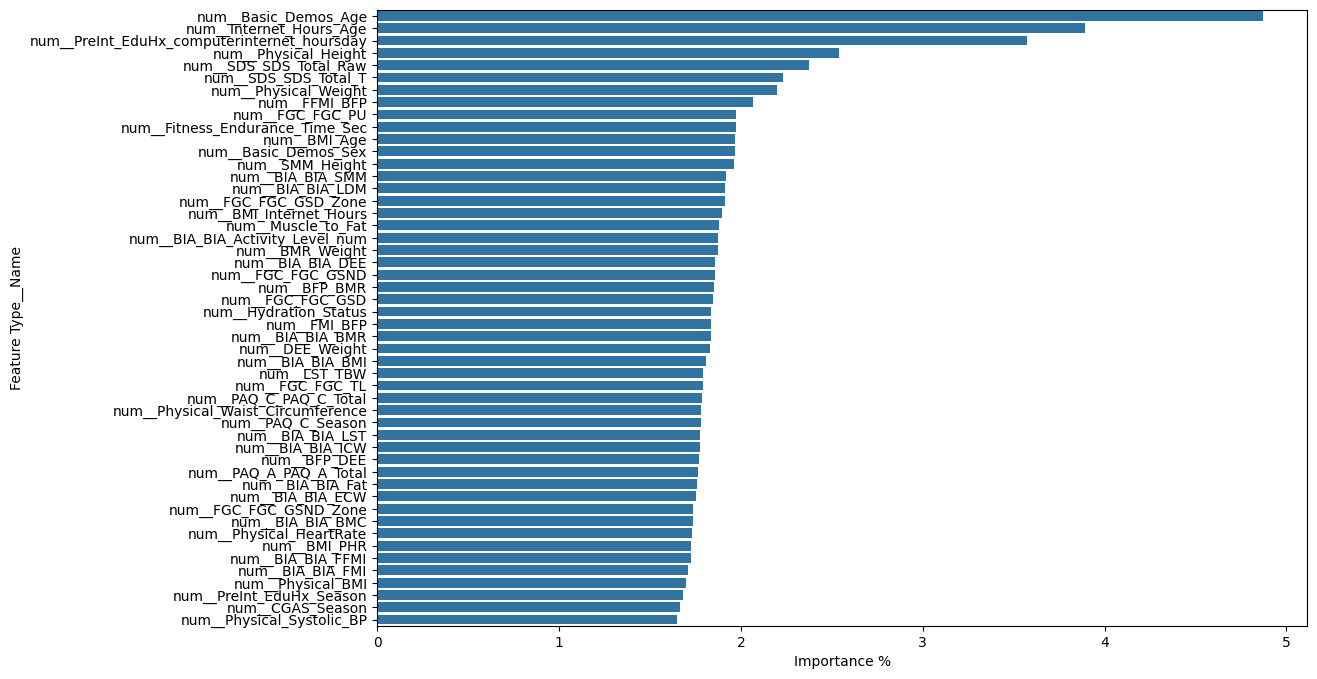

In [17]:
classification_trainer.show_feature_importance(X)

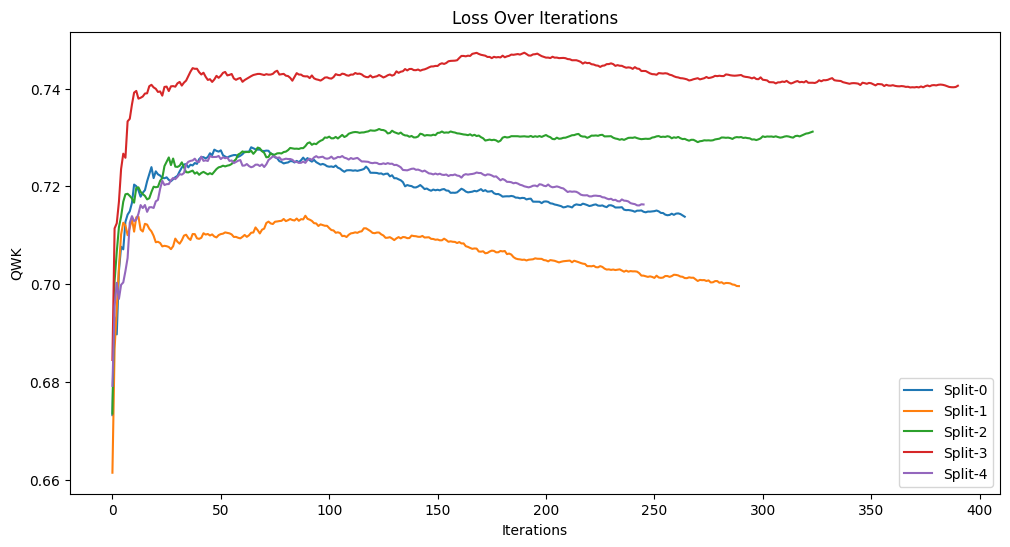

In [18]:
classification_trainer.show_loss()

## <p style="padding:15px; background-color:#b48dda; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px; margin-bottom: -60px">Train sii Regression Model</p>

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; background-color: #f6f5f5; text-align:left">

Predict sii as a linear value and then round it up to integer. Surprisingly enough, this yields more accurate QWK scores than a classifier.<br>
Basic_Demos_Age also takes a greater weight to the prediction compared to classification.<br>
Loss is still sparse, but far mor stable than classification.

In [19]:
# pick a model, and a trainer
sii_regression_model_type = XGBRegressorWrapper(early_stopping_rounds=50)
sii_regression_trainer = AccurateCrossTrainer(pipeline, sii_regression_model_type, metric=AccuracyMetric.RMSE)
sii_regression_optimizer = CustomGridOptimizer(sii_regression_trainer, sii_regression_model_type, direction=OptimizationDirection.MINIMIZE)

# optimize param
#sii_regression_optimized_params = regression_optimizer.tune(X, y, 0.03) # Code used for optimization
sii_regression_optimized_params = {
 'objective': 'reg:squarederror',
 'learning_rate': 0.03,
 'max_depth': 4,
 'min_child_weight': 5,
 'gamma': 0.4,
 'subsample': 0.7,
 'colsample_bytree': 0.9,
 'n_jobs': -1,
 'reg_alpha': 10
}


# Train model
accuracy, sii_regression_iterations, oof_prediction_comparisons = sii_regression_trainer.validate_model(X, y, log_level=0, 
                                                                           params=sii_regression_optimized_params,
                                                                           output_prediction_comparison=True)
print(f"Cross RMSE score: {accuracy}")

oof_prediction_comparisons['rounded_predictions'] =  oof_prediction_comparisons['predictions'].round()

from sklearn.metrics import cohen_kappa_score
sii_regression_qwk_score = cohen_kappa_score(
    oof_prediction_comparisons['real_values'], 
    oof_prediction_comparisons['rounded_predictions'], 
    weights='quadratic'
)
print(f"Cross QWK score: {sii_regression_qwk_score}")

Cross RMSE score: 0.6687298724920646
Cross QWK score: 0.3803419957526729


                                          feats  importance
0                          num__Basic_Demos_Age   12.604692
1                       num__Internet_Hours_Age   11.296445
2                          num__Physical_Height    3.799580
3                        num__SDS_SDS_Total_Raw    3.504323
4                          num__SDS_SDS_Total_T    3.211869
5   num__PreInt_EduHx_computerinternet_hoursday    2.846984
6             num__Physical_Waist_Circumference    2.480351
7                          num__Physical_Weight    2.474722
8                          num__Basic_Demos_Sex    2.128864
9                              num__BIA_BIA_LDM    2.079022
10                                 num__BMI_Age    1.983609
11                      num__BMI_Internet_Hours    1.914359
12                              num__FGC_FGC_PU    1.688301
13                            num__FGC_FGC_GSND    1.667690
14                           num__Muscle_to_Fat    1.659184
15                                 num__

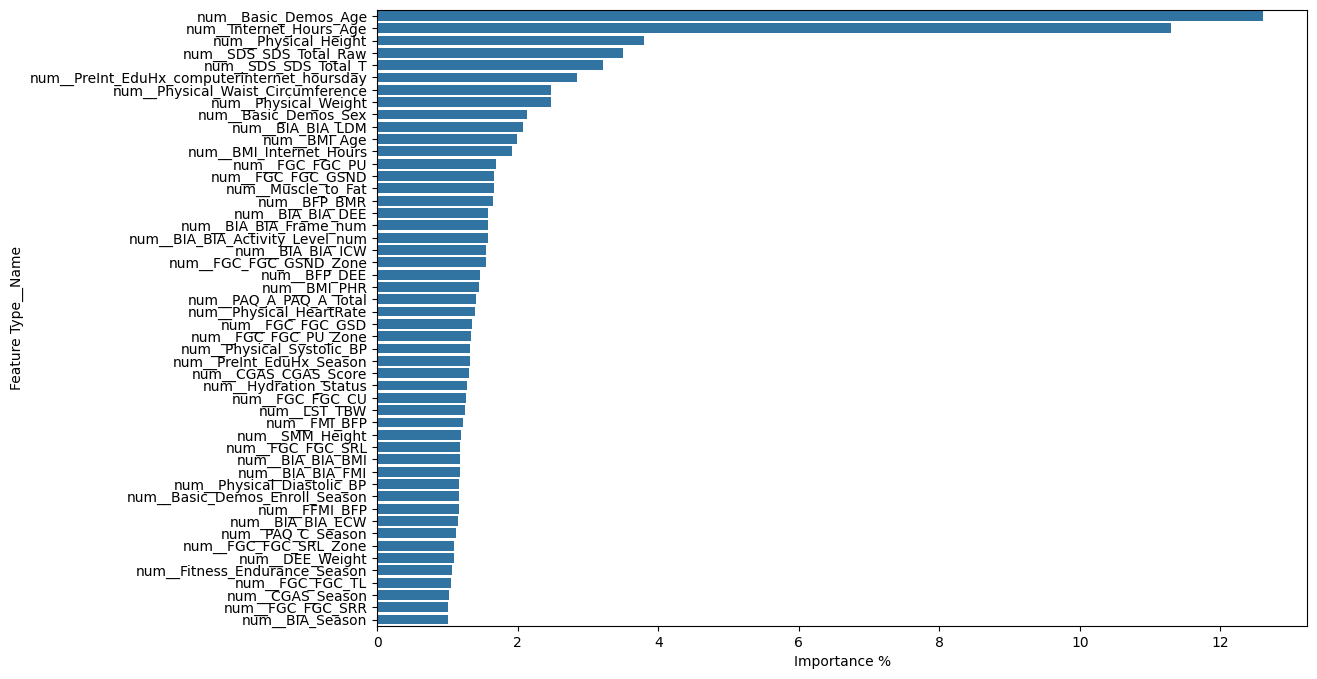

In [20]:
sii_regression_trainer.show_feature_importance(X)

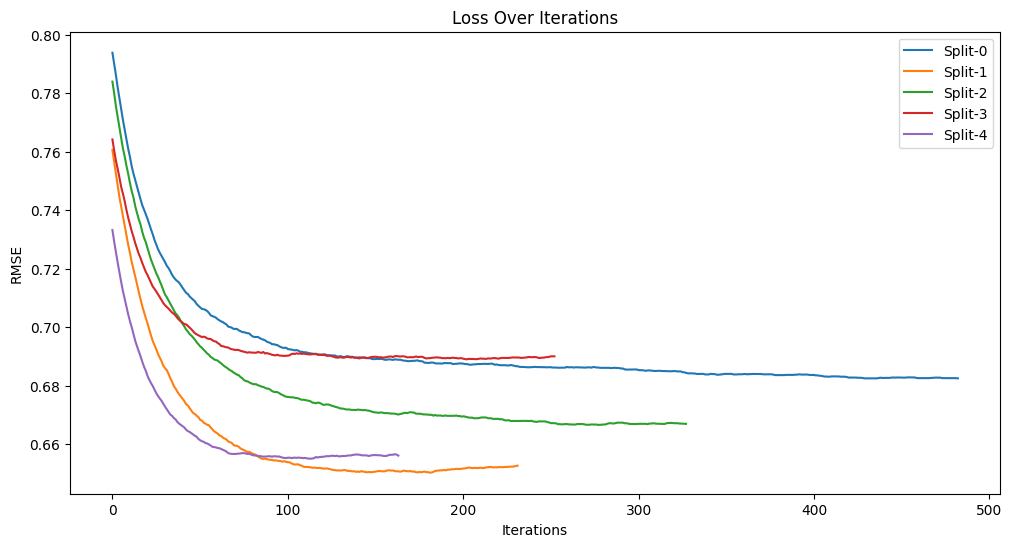

In [21]:
sii_regression_trainer.show_loss()

## <p style="padding:15px; background-color:#b48dda; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px; margin-bottom: -60px">Train PCIAT Regression Model</p>

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; background-color: #f6f5f5; text-align:left"> 

Predict PCIAT_PCIAT_Total first, and then compute iss. This results in the best QWK scores.<br>
Basic_Demos_Age also takes a greater weight to the prediction compared to classification.<br>
Loss is still sparse, but far mor stable than classification.

In [22]:
# extract the regression target
pciat_regression_y = raw_data['PCIAT_PCIAT_Total']

# pick a model, and a trainer
pciat_regression_model_type = XGBRegressorWrapper(early_stopping_rounds=50)
pciat_regression_trainer = AccurateCrossTrainer(pipeline, pciat_regression_model_type, metric=AccuracyMetric.RMSE)
pciat_regression_optimizer = CustomGridOptimizer(pciat_regression_trainer, pciat_regression_model_type, direction=OptimizationDirection.MINIMIZE)

# optimize param
#regression_optimized_params = regression_optimizer.tune(X, pciat_regression_y, 0.03) # Code used for optimization
pciat_regression_optimized_params = {
 'objective': 'reg:squarederror',
 'learning_rate': 0.03,
 'max_depth': 3,
 'min_child_weight': 5,
 'gamma': 0.0,
 'subsample': 0.6,
 'colsample_bytree': 0.85,
 'n_jobs': -1,
 'reg_alpha': 0.5
}

# Train model
accuracy, pciat_regression_iterations, oof_prediction_comparisons = pciat_regression_trainer.validate_model(X, pciat_regression_y, log_level=0, 
                                                                                           params=pciat_regression_optimized_params,
                                                                                           output_prediction_comparison=True)
print(f"Cross RMSE score: {accuracy}")

# add real values to oof prediction dataframe (leverage indexes)
oof_prediction_comparisons['real_sii'] = y

Cross RMSE score: 17.19519113785531


<div style="border-radius:12px; border:#b48dda solid; padding: 15px; background-color: #f6f5f5; text-align:left"> 

### define a utility method to calculate sii

In [23]:
# define a utility method to calculate sii
def calculate_sii(pciat_scores, weight):
    pciat_scores = pciat_scores * weight
    bins = pd.cut(pciat_scores, bins=[-float('inf'), 30, 50, 80, float('inf')], labels=[0, 1, 2, 3], right=False)
    return bins.astype(int)

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; background-color: #f6f5f5; text-align:left"> 

### optimize sii weight 
By chance, i found that 1.2525 performs better than optuna tuned weight, i'll keep that

In [24]:
pciat_weight = 1.2525

In [25]:
%%script false --no-raise-error # skip cell execution
import optuna
from functools import partial

def objective(trial, real_sii_values, pciat_scores):
    # Define the weights for the predictions from each model
    weight = trial.suggest_float("weight", 0.8, 1.5)

    # Calculate the weighted prediction
    sii_predictions = calculate_sii(pciat_scores, weight)

    # Calculate the score for the weighted prediction
    score = cohen_kappa_score(sii_predictions, real_sii_values)
    return score


# set log level
optuna.logging.set_verbosity(optuna.logging.ERROR)

# create a study
sampler = optuna.samplers.CmaEsSampler(seed=0)
pruner = optuna.pruners.HyperbandPruner()
study = optuna.create_study(sampler=sampler, pruner=pruner, study_name="OptSiiWeight", direction='maximize')

# define an objective and start the study
objective_partial = partial(objective, real_sii_values=oof_prediction_comparisons['real_sii'], pciat_scores=oof_prediction_comparisons['predictions'])
study.optimize(objective_partial, n_trials=4000)

print(study.best_params)
pciat_weight = study.best_params['weight']

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; background-color: #f6f5f5; text-align:left"> 

### Calculate SII and compute QWK

In [26]:
# calculate sii and add it to oof prediction dataframe (leverage indexes)
oof_prediction_comparisons['predicted_sii'] =  calculate_sii(oof_prediction_comparisons['predictions'], pciat_weight)

# compute QWK score
from sklearn.metrics import cohen_kappa_score
regression_qwk_score = cohen_kappa_score(
    oof_prediction_comparisons['real_sii'], 
    oof_prediction_comparisons['predicted_sii'], 
    weights='quadratic'
)
print(f"Cross QWK score: {regression_qwk_score}")

Cross QWK score: 0.4392337759988675


                                          feats  importance
0                          num__Basic_Demos_Age   10.107078
1                       num__Internet_Hours_Age    7.308980
2                          num__Physical_Height    4.398254
3   num__PreInt_EduHx_computerinternet_hoursday    4.337503
4                              num__BIA_BIA_ICW    3.165652
5                        num__SDS_SDS_Total_Raw    2.774850
6                          num__Physical_Weight    2.645113
7                                  num__BMI_Age    2.523396
8                          num__SDS_SDS_Total_T    2.410602
9                          num__FGC_FGC_PU_Zone    2.328421
10                      num__BMI_Internet_Hours    2.017268
11                        num__FGC_FGC_SRL_Zone    1.958923
12                             num__BIA_BIA_DEE    1.954378
13                         num__Basic_Demos_Sex    1.881184
14                       num__BIA_BIA_Frame_num    1.880196
15                              num__FGC

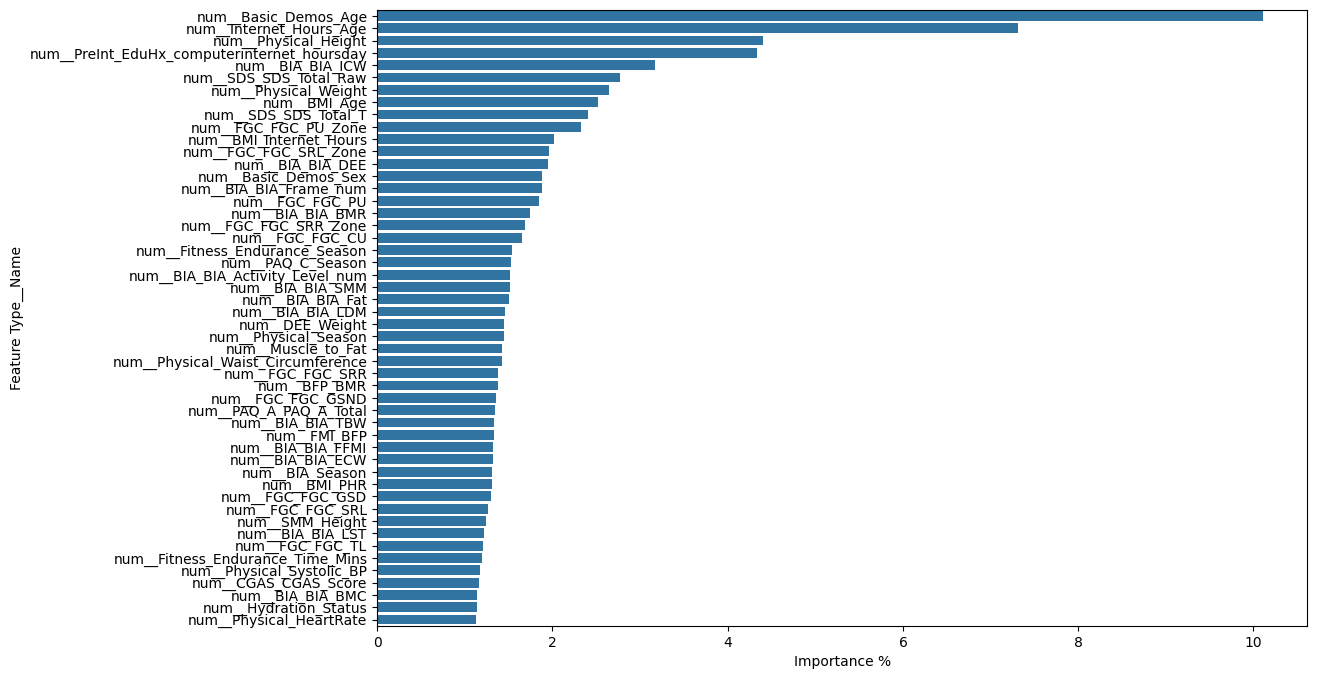

In [27]:
pciat_regression_trainer.show_feature_importance(X)

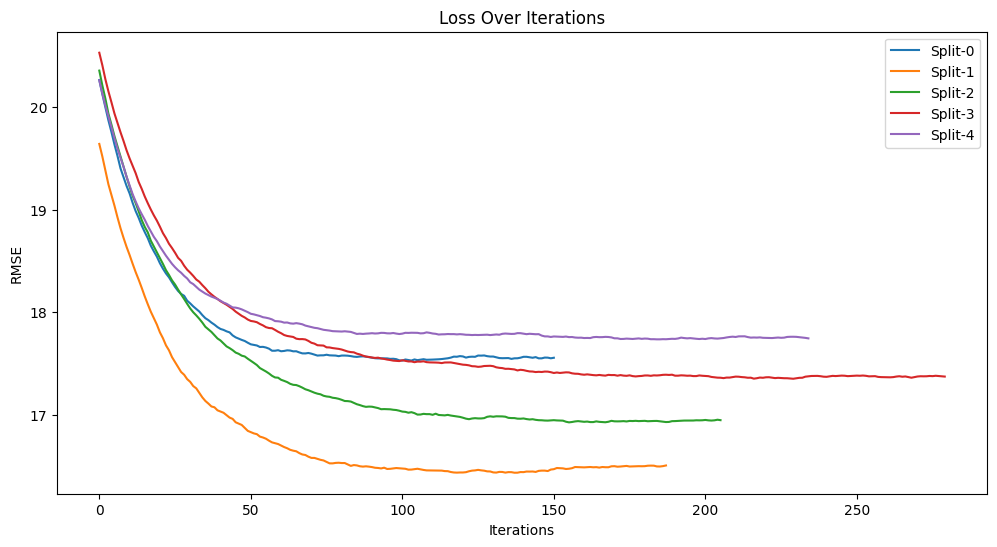

In [28]:
pciat_regression_trainer.show_loss()

## <p style="padding:15px; background-color:#b48dda; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px; margin-bottom: -60px">Train TabNet PCIAT Regression Model</p>

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; background-color: #f6f5f5; text-align:left"> 
 
Data is noisy, so it's worth exploring a deep tabular data learning based solution<br>
Predict PCIAT_PCIAT_Total first, and then compute iss. This results in the best QWK scores.<br>

In [29]:
# extract the regression target
pciat_regression_y = raw_data['PCIAT_PCIAT_Total']

# pick a model, and a trainer
pciat_tabnet_regression_model_type = TabNetRegressorWrapper(early_stopping_rounds=200)
pciat_tabnet_regression_trainer = AccurateCrossTrainer(pipeline, pciat_tabnet_regression_model_type, metric=AccuracyMetric.RMSE)
pciat_tabnet_regression_optimizer = OptunaOptimizer(pciat_tabnet_regression_trainer, pciat_tabnet_regression_model_type, direction=OptimizationDirection.MINIMIZE)

# optimize param
#pciat_tabnet_regression_optimized_params = regression_optimizer.tune(X, pciat_regression_y, 0.03)
# optimization took more than 12 hours, trying with a set of premade params
pciat_tabnet_regression_optimized_params = {
    'n_d': 64,              # Width of the decision prediction layer
    'n_a': 64,              # Width of the attention embedding for each step
    'n_steps': 5,           # Number of steps in the architecture
    'gamma': 1.5,           # Coefficient for feature selection regularization
    'n_independent': 2,     # Number of independent GLU layer in each GLU block
    'n_shared': 2,          # Number of shared GLU layer in each GLU block
    'lambda_sparse': 1e-4,  # Sparsity regularization
    'optimizer_fn': torch.optim.Adam,
    'optimizer_params': dict(lr=2e-2, weight_decay=1e-5),
    'mask_type': 'entmax',
    'scheduler_params': dict(mode="min", patience=10, min_lr=1e-5, factor=0.5),
    'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,
    'verbose': 1,
}

# Train model
accuracy, pciat_tabnet_regression_iterations, oof_prediction_comparisons = pciat_tabnet_regression_trainer.validate_model(X, pciat_regression_y, log_level=0, 
                                                                                           params=pciat_tabnet_regression_optimized_params,
                                                                                           output_prediction_comparison=True)
print(f"Cross RMSE score: {accuracy}")

# add real values to oof prediction dataframe (leverage indexes)
oof_prediction_comparisons['real_sii'] = y

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 986.20256| valid_rmse: 125.09219|  0:00:00s
epoch 1  | loss: 729.02355| valid_rmse: 189.62641|  0:00:01s
epoch 2  | loss: 569.82947| valid_rmse: 200.49215|  0:00:01s
epoch 3  | loss: 465.93594| valid_rmse: 203.00725|  0:00:02s
epoch 4  | loss: 418.73106| valid_rmse: 196.21775|  0:00:02s
epoch 5  | loss: 416.54493| valid_rmse: 127.84668|  0:00:03s
epoch 6  | loss: 391.26883| valid_rmse: 100.78183|  0:00:03s
epoch 7  | loss: 370.87354| valid_rmse: 69.92364|  0:00:04s
epoch 8  | loss: 350.67923| valid_rmse: 68.25974|  0:00:04s
epoch 9  | loss: 356.62235| valid_rmse: 53.07415|  0:00:05s
epoch 10 | loss: 348.4004| valid_rmse: 62.45331|  0:00:05s
epoch 11 | loss: 337.74811| valid_rmse: 32.46874|  0:00:06s
epoch 12 | loss: 332.21061| valid_rmse: 26.92738|  0:00:06s
epoch 13 | loss: 327.19978| valid_rmse: 26.97262|  0:00:07s
epoch 14 | loss: 322.64937| valid_rmse: 26.99825|  0:00:07s
epoch 15 | loss: 319.98983| valid_rmse: 30.2645 |  0:00:08s
epoch 16 | loss: 319.93789| valid_

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 995.78628| valid_rmse: 140.63297|  0:00:00s
epoch 1  | loss: 738.87587| valid_rmse: 117.01949|  0:00:01s
epoch 2  | loss: 552.95294| valid_rmse: 131.40613|  0:00:01s
epoch 3  | loss: 437.62124| valid_rmse: 196.66264|  0:00:02s
epoch 4  | loss: 443.3294| valid_rmse: 140.67433|  0:00:02s
epoch 5  | loss: 421.45102| valid_rmse: 106.57613|  0:00:03s
epoch 6  | loss: 393.3   | valid_rmse: 56.13944|  0:00:03s
epoch 7  | loss: 372.81624| valid_rmse: 50.64416|  0:00:04s
epoch 8  | loss: 361.8935| valid_rmse: 42.37468|  0:00:04s
epoch 9  | loss: 366.92345| valid_rmse: 37.86045|  0:00:05s
epoch 10 | loss: 348.04936| valid_rmse: 38.84039|  0:00:05s
epoch 11 | loss: 353.23802| valid_rmse: 42.02268|  0:00:06s
epoch 12 | loss: 347.8069| valid_rmse: 36.97677|  0:00:06s
epoch 13 | loss: 340.08288| valid_rmse: 48.24277|  0:00:07s
epoch 14 | loss: 332.01421| valid_rmse: 50.04432|  0:00:07s
epoch 15 | loss: 326.22489| valid_rmse: 29.59725|  0:00:08s
epoch 16 | loss: 335.80972| valid_rmse

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 976.71579| valid_rmse: 210.12796|  0:00:00s
epoch 1  | loss: 697.56563| valid_rmse: 163.15776|  0:00:00s
epoch 2  | loss: 526.78083| valid_rmse: 188.79066|  0:00:01s
epoch 3  | loss: 458.86368| valid_rmse: 125.13504|  0:00:01s
epoch 4  | loss: 435.81052| valid_rmse: 109.8135|  0:00:02s
epoch 5  | loss: 393.07089| valid_rmse: 68.46043|  0:00:02s
epoch 6  | loss: 373.00123| valid_rmse: 48.32483|  0:00:03s
epoch 7  | loss: 366.62609| valid_rmse: 47.61652|  0:00:03s
epoch 8  | loss: 356.27449| valid_rmse: 41.85697|  0:00:04s
epoch 9  | loss: 359.57896| valid_rmse: 40.20028|  0:00:04s
epoch 10 | loss: 346.65981| valid_rmse: 39.90167|  0:00:05s
epoch 11 | loss: 347.21319| valid_rmse: 41.80967|  0:00:06s
epoch 12 | loss: 332.06664| valid_rmse: 34.67188|  0:00:06s
epoch 13 | loss: 329.72623| valid_rmse: 28.97826|  0:00:07s
epoch 14 | loss: 334.73813| valid_rmse: 25.41737|  0:00:07s
epoch 15 | loss: 331.35576| valid_rmse: 29.3774 |  0:00:08s
epoch 16 | loss: 325.25878| valid_rm

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 991.35483| valid_rmse: 158.84004|  0:00:00s
epoch 1  | loss: 733.59766| valid_rmse: 207.32683|  0:00:01s
epoch 2  | loss: 542.27899| valid_rmse: 184.45224|  0:00:01s
epoch 3  | loss: 436.47641| valid_rmse: 181.09799|  0:00:02s
epoch 4  | loss: 412.36772| valid_rmse: 111.66315|  0:00:02s
epoch 5  | loss: 381.62935| valid_rmse: 91.51393|  0:00:02s
epoch 6  | loss: 360.57782| valid_rmse: 85.22376|  0:00:03s
epoch 7  | loss: 360.0661| valid_rmse: 74.98661|  0:00:03s
epoch 8  | loss: 336.42259| valid_rmse: 69.21417|  0:00:04s
epoch 9  | loss: 345.08637| valid_rmse: 63.25215|  0:00:04s
epoch 10 | loss: 333.35821| valid_rmse: 41.81344|  0:00:05s
epoch 11 | loss: 332.29509| valid_rmse: 40.21522|  0:00:05s
epoch 12 | loss: 321.68417| valid_rmse: 47.53654|  0:00:06s
epoch 13 | loss: 312.48538| valid_rmse: 41.27822|  0:00:06s
epoch 14 | loss: 317.84661| valid_rmse: 29.09617|  0:00:07s
epoch 15 | loss: 311.58992| valid_rmse: 30.49695|  0:00:07s
epoch 16 | loss: 307.48567| valid_rm

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 992.50728| valid_rmse: 1117.92139|  0:00:00s
epoch 1  | loss: 652.72942| valid_rmse: 1013.90054|  0:00:00s
epoch 2  | loss: 489.2555| valid_rmse: 410.40812|  0:00:01s
epoch 3  | loss: 447.65558| valid_rmse: 502.23281|  0:00:01s
epoch 4  | loss: 420.25644| valid_rmse: 323.20457|  0:00:02s
epoch 5  | loss: 378.91816| valid_rmse: 873.90902|  0:00:03s
epoch 6  | loss: 366.66262| valid_rmse: 1378.01406|  0:00:03s
epoch 7  | loss: 354.67029| valid_rmse: 1663.47194|  0:00:04s
epoch 8  | loss: 338.18696| valid_rmse: 1414.86759|  0:00:04s
epoch 9  | loss: 339.20621| valid_rmse: 928.59847|  0:00:05s
epoch 10 | loss: 329.91558| valid_rmse: 1081.30985|  0:00:05s
epoch 11 | loss: 333.02639| valid_rmse: 352.86659|  0:00:06s
epoch 12 | loss: 329.90956| valid_rmse: 3356.73178|  0:00:06s
epoch 13 | loss: 309.66973| valid_rmse: 1698.80755|  0:00:07s
epoch 14 | loss: 312.30389| valid_rmse: 38.41219|  0:00:07s
epoch 15 | loss: 309.53969| valid_rmse: 42.74478|  0:00:08s
epoch 16 | loss: 30

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Cross RMSE score: 19.156289086877287


In [30]:
# define a utility method to calculate sii
def calculate_sii(pciat_scores, weight):
    pciat_scores = pciat_scores * weight
    bins = pd.cut(pciat_scores, bins=[-float('inf'), 30, 50, 80, float('inf')], labels=[0, 1, 2, 3], right=False)
    return bins.astype(int)

# calculate sii and add it to oof prediction dataframe (leverage indexes)
oof_prediction_comparisons['predicted_sii'] =  calculate_sii(oof_prediction_comparisons['predictions'], pciat_weight)

# compute QWK score
from sklearn.metrics import cohen_kappa_score
regression_qwk_score = cohen_kappa_score(
    oof_prediction_comparisons['real_sii'], 
    oof_prediction_comparisons['predicted_sii'], 
    weights='quadratic'
)
print(f"Cross QWK score: {regression_qwk_score}")

Cross QWK score: 0.3259876377317925


## <p style="padding:15px; background-color:#b48dda; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px; margin-bottom: -60px">Train PCIAT Regression Ensemble</p>

<div style="border-radius:12px; border:#b48dda solid; padding: 15px; background-color: #f6f5f5; text-align:left"> 

RMSE leaderboard shows minimal discrepancies (max 0.1 RMSE).<br>
Ensemble RMSE is slightly worse than a single XGB model, but still greatly helps stabilizing model outputs, yelding an increased LB QWK score.

In [31]:
##%%script false --no-raise-error # skip cell execution

# extract the regression target
pciat_regression_y = raw_data['PCIAT_PCIAT_Total']

# XGB model, trainer and optimizer
xgb_model_type = XGBRegressorWrapper(early_stopping_rounds=50)
xgb_trainer = CachedAccurateCrossTrainer(pipeline, xgb_model_type, X, pciat_regression_y, metric=AccuracyMetric.RMSE)
xgb_optimizer = CustomGridOptimizer(xgb_trainer, xgb_model_type, direction=OptimizationDirection.MINIMIZE)

# Catboost model, trainer and optimizer
catboost_model_type = CatBoostRegressorWrapper(early_stopping_rounds=50)
catboost_trainer = CachedAccurateCrossTrainer(pipeline, catboost_model_type, X, pciat_regression_y, metric=AccuracyMetric.RMSE)
catboost_optimizer = OptunaOptimizer(catboost_trainer, catboost_model_type, direction=OptimizationDirection.MINIMIZE)

# LGBM model, trainer and optimizer
lgbm_model_type = LGBMRegressorWrapper(early_stopping_rounds=50)
lgbm_trainer = CachedAccurateCrossTrainer(pipeline, lgbm_model_type, X, pciat_regression_y, metric=AccuracyMetric.RMSE)
lgbm_optimizer = CustomGridOptimizer(lgbm_trainer, lgbm_model_type, direction=OptimizationDirection.MINIMIZE)

# TabNet model,trainer and optimizer
tabnet_model_type = TabNetRegressorWrapper(early_stopping_rounds=200)
tabnet_trainer = AccurateCrossTrainer(pipeline, tabnet_model_type, metric=AccuracyMetric.RMSE)
tabnet_optimizer = OptunaOptimizer(tabnet_trainer, tabnet_model_type, direction=OptimizationDirection.MINIMIZE)


# Define ensemble
# to speed up submission, optimizer was provided on the first run only
ensemble = WeightedEnsemble(members=[
    {
        'trainer': xgb_trainer,
        'params': {
            'objective': 'reg:squarederror',
            'learning_rate': 0.03,
            'max_depth': 3,
            'min_child_weight': 4,
            'gamma': 0.0,
            'subsample': 0.6,
            'colsample_bytree': 0.7,
            'n_jobs': -1,
            'reg_alpha': 100
        },
        'optimizer': None
    },
    {
        'trainer': catboost_trainer,
        'params': {
            'loss_function': 'RMSE',
            'grow_policy': 'SymmetricTree',
            'bagging_temperature': 1.0573025149057662,
            'learning_rate': 0.03,
            'depth': 7,
            'l2_leaf_reg': 5.283378489381951,
            'min_data_in_leaf': 37,
            'thread_count': -1,
            'colsample_bylevel': 0.831591113092739,
            'random_strength': 2.683007858572137,
            'max_bin': 315
        },
        'optimizer': None
    },
    {
        'trainer': lgbm_trainer,
        'params': {
            'boosting_type': 'gbdt',
            'force_col_wise': True,
            'num_leaves': 64,
            'max_depth': 8,
            'learning_rate': 0.03,
            'n_estimators': 20000,
            'min_child_samples': 20,
            'reg_alpha': 10,
            'reg_lambda': 0.05,
            'colsample_bytree': 0.75,
            'colsample_bynode': 0.6,
            'extra_trees': True,
            'max_bin': 255,
            'subsample': 0.6,
            'n_jobs': -1,
            'random_state': 0
        },
        'optimizer': None
    },
    {
        'trainer': tabnet_trainer,
        # optimization took more than 12 hours, trying with a set of premade params
        'params': {
            'n_d': 64,              # Width of the decision prediction layer
            'n_a': 64,              # Width of the attention embedding for each step
            'n_steps': 5,           # Number of steps in the architecture
            'gamma': 1.5,           # Coefficient for feature selection regularization
            'n_independent': 2,     # Number of independent GLU layer in each GLU block
            'n_shared': 2,          # Number of shared GLU layer in each GLU block
            'lambda_sparse': 1e-4,  # Sparsity regularization
            'optimizer_fn': torch.optim.Adam,
            'optimizer_params': dict(lr=2e-2, weight_decay=1e-5),
            'mask_type': 'entmax',
            'scheduler_params': dict(mode="min", patience=10, min_lr=1e-5, factor=0.5),
            'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,
            'verbose': 1,
        },
        'optimizer': None
    }
])

# train models and compute a cross-validation score leaderboard
accuracy = ensemble.validate_models_and_show_leaderboard(X, pciat_regression_y)

print(f"Ensemble Cross RMSE score: {accuracy}")

Training XGBRegressorWrapper...
Training CatBoostRegressorWrapper...
Training LGBMRegressorWrapper...
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 74
[LightGBM] [Info] Start training from score 27.372029
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 986.20256| valid_rmse: 125.09219|  0:00:00s
epoch 1  | loss: 729.02355| valid_rmse: 189.62641|  0:00:00s
epoch 2  | loss: 569.82947| valid_rmse: 200.49215|  0:00:01s
epoch 3  | loss: 465.93594| valid_rmse: 203.00725|  0:00:01s
epoch 4  | loss: 418.73106| valid_rmse: 196.21775|  0:00:02s
epoch 5  | loss: 416.54493| valid_rmse: 127.84668|  0:00:02s
epoch 6  | loss: 391.26883| valid_rmse: 100.78183|  0:00:03s
epoch 7  | loss: 370.87354| valid_rmse: 69.92364|  0:00:03s
epoch 8  | loss: 350.67923| valid_rmse: 68.25974|  0:00:04s
epoch 9  | loss: 356.62235| valid_rmse: 53.07415|  0:00:05s
epoch 10 | loss: 348.4004| valid_rmse: 62.45331|  0:00:05s
epoch 11 | loss: 337.74811| valid_rmse: 32.46874|  0:00:06s
epoch 12 | loss: 332.21061| valid_rmse: 26.92738|  0:00:06s
epoch 13 | loss: 327.19978| valid_rmse: 26.97262|  0:00:07s
epoch 14 | loss: 322.64937| valid_rmse: 26.99825|  0:00:07s
epoch 15 | loss: 319.98983| valid_rmse: 30.2645 |  0:00:08s
epoch 16 | loss: 319.93789| valid_

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 995.78628| valid_rmse: 140.63297|  0:00:00s
epoch 1  | loss: 738.87587| valid_rmse: 117.01949|  0:00:01s
epoch 2  | loss: 552.95294| valid_rmse: 131.40613|  0:00:01s
epoch 3  | loss: 437.62124| valid_rmse: 196.66264|  0:00:02s
epoch 4  | loss: 443.3294| valid_rmse: 140.67433|  0:00:02s
epoch 5  | loss: 421.45102| valid_rmse: 106.57613|  0:00:03s
epoch 6  | loss: 393.3   | valid_rmse: 56.13944|  0:00:03s
epoch 7  | loss: 372.81624| valid_rmse: 50.64416|  0:00:04s
epoch 8  | loss: 361.8935| valid_rmse: 42.37468|  0:00:04s
epoch 9  | loss: 366.92345| valid_rmse: 37.86045|  0:00:05s
epoch 10 | loss: 348.04936| valid_rmse: 38.84039|  0:00:05s
epoch 11 | loss: 353.23802| valid_rmse: 42.02268|  0:00:06s
epoch 12 | loss: 347.8069| valid_rmse: 36.97677|  0:00:06s
epoch 13 | loss: 340.08288| valid_rmse: 48.24277|  0:00:07s
epoch 14 | loss: 332.01421| valid_rmse: 50.04432|  0:00:07s
epoch 15 | loss: 326.22489| valid_rmse: 29.59725|  0:00:08s
epoch 16 | loss: 335.80972| valid_rmse

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 976.71579| valid_rmse: 210.12796|  0:00:00s
epoch 1  | loss: 697.56563| valid_rmse: 163.15776|  0:00:00s
epoch 2  | loss: 526.78083| valid_rmse: 188.79066|  0:00:01s
epoch 3  | loss: 458.86368| valid_rmse: 125.13504|  0:00:01s
epoch 4  | loss: 435.81052| valid_rmse: 109.8135|  0:00:02s
epoch 5  | loss: 393.07089| valid_rmse: 68.46043|  0:00:02s
epoch 6  | loss: 373.00123| valid_rmse: 48.32483|  0:00:03s
epoch 7  | loss: 366.62609| valid_rmse: 47.61652|  0:00:03s
epoch 8  | loss: 356.27449| valid_rmse: 41.85697|  0:00:04s
epoch 9  | loss: 359.57896| valid_rmse: 40.20028|  0:00:05s
epoch 10 | loss: 346.65981| valid_rmse: 39.90167|  0:00:05s
epoch 11 | loss: 347.21319| valid_rmse: 41.80967|  0:00:06s
epoch 12 | loss: 332.06664| valid_rmse: 34.67188|  0:00:06s
epoch 13 | loss: 329.72623| valid_rmse: 28.97826|  0:00:07s
epoch 14 | loss: 334.73813| valid_rmse: 25.41737|  0:00:07s
epoch 15 | loss: 331.35576| valid_rmse: 29.3774 |  0:00:08s
epoch 16 | loss: 325.25878| valid_rm

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 991.35483| valid_rmse: 158.84004|  0:00:00s
epoch 1  | loss: 733.59766| valid_rmse: 207.32683|  0:00:00s
epoch 2  | loss: 542.27899| valid_rmse: 184.45224|  0:00:01s
epoch 3  | loss: 436.47641| valid_rmse: 181.09799|  0:00:01s
epoch 4  | loss: 412.36772| valid_rmse: 111.66315|  0:00:02s
epoch 5  | loss: 381.62935| valid_rmse: 91.51393|  0:00:02s
epoch 6  | loss: 360.57782| valid_rmse: 85.22376|  0:00:03s
epoch 7  | loss: 360.0661| valid_rmse: 74.98661|  0:00:03s
epoch 8  | loss: 336.42259| valid_rmse: 69.21417|  0:00:04s
epoch 9  | loss: 345.08637| valid_rmse: 63.25215|  0:00:04s
epoch 10 | loss: 333.35821| valid_rmse: 41.81344|  0:00:05s
epoch 11 | loss: 332.29509| valid_rmse: 40.21522|  0:00:05s
epoch 12 | loss: 321.68417| valid_rmse: 47.53654|  0:00:06s
epoch 13 | loss: 312.48538| valid_rmse: 41.27822|  0:00:06s
epoch 14 | loss: 317.84661| valid_rmse: 29.09617|  0:00:07s
epoch 15 | loss: 311.58992| valid_rmse: 30.49695|  0:00:07s
epoch 16 | loss: 307.48567| valid_rm

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 992.50728| valid_rmse: 1117.92139|  0:00:00s
epoch 1  | loss: 652.72942| valid_rmse: 1013.90054|  0:00:01s
epoch 2  | loss: 489.2555| valid_rmse: 410.40812|  0:00:01s
epoch 3  | loss: 447.65558| valid_rmse: 502.23281|  0:00:02s
epoch 4  | loss: 420.25644| valid_rmse: 323.20457|  0:00:02s
epoch 5  | loss: 378.91816| valid_rmse: 873.90902|  0:00:03s
epoch 6  | loss: 366.66262| valid_rmse: 1378.01406|  0:00:03s
epoch 7  | loss: 354.67029| valid_rmse: 1663.47194|  0:00:04s
epoch 8  | loss: 338.18696| valid_rmse: 1414.86759|  0:00:04s
epoch 9  | loss: 339.20621| valid_rmse: 928.59847|  0:00:05s
epoch 10 | loss: 329.91558| valid_rmse: 1081.30985|  0:00:05s
epoch 11 | loss: 333.02639| valid_rmse: 352.86659|  0:00:06s
epoch 12 | loss: 329.90956| valid_rmse: 3356.73178|  0:00:06s
epoch 13 | loss: 309.66973| valid_rmse: 1698.80755|  0:00:07s
epoch 14 | loss: 312.30389| valid_rmse: 38.41219|  0:00:07s
epoch 15 | loss: 309.53969| valid_rmse: 42.74478|  0:00:08s
epoch 16 | loss: 30

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


                 model_name   accuracy  iterations
0       XGBRegressorWrapper  17.117496         190
2      LGBMRegressorWrapper  17.156238         118
1  CatBoostRegressorWrapper  17.181546         269
3    TabNetRegressorWrapper  19.156289          83
Optimizing ensemble weights...


Ensemble Cross RMSE score: 17.652892295262745


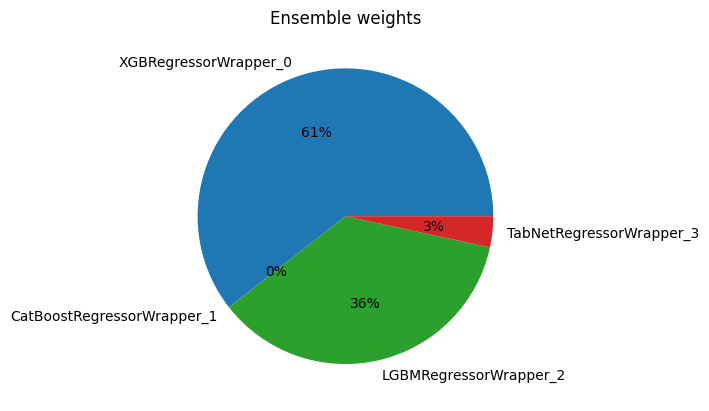

In [32]:
##%%script false --no-raise-error # skip cell execution

# show ensemble weights
ensemble.show_weights()

## <p style="padding:15px; background-color:#b48dda; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px; margin-bottom: -30px; margin-top: 50px;">Train complete model on all data</p>

In [33]:
# fit complete_model on all data from the training data
ensemble.train(X, pciat_regression_y)
complete_model = ensemble
#complete_model = pciat_regression_trainer.train_model(X, pciat_regression_y, iterations=pciat_regression_iterations, params=pciat_regression_optimized_params)


Training XGBRegressorWrapper...
Training CatBoostRegressorWrapper...
Training LGBMRegressorWrapper...
[LightGBM] [Info] Total Bins 9820
[LightGBM] [Info] Number of data points in the train set: 2736, number of used features: 74
[LightGBM] [Info] Start training from score 27.896199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 971.71698|  0:00:00s
epoch 1  | loss: 695.61259|  0:00:01s
epoch 2  | loss: 512.09622|  0:00:01s
epoch 3  | loss: 444.86955|  0:00:02s
epoch 4  | loss: 425.77964|  0:00:02s
epoch 5  | loss: 389.10575|  0:00:03s
epoch 6  | loss: 363.35038|  0:00:03s
epoch 7  | loss: 360.55164|  0:00:04s
epoch 8  | loss: 350.91245|  0:00:04s
epoch 9  | loss: 343.97566|  0:00:05s
epoch 10 | loss: 340.47154|  0:00:05s
epoch 11 | loss: 336.06778|  0:00:06s
epoch 12 | loss: 330.95567|  0:00:06s
epoch 13 | loss: 320.45344|  0:00:07s
epoch 14 | loss: 320.39602|  0:00:07s
epoch 15 | loss: 323.32314|  0:00:08s
epoch 16 | loss: 321.36085|  0:00:08s
epoch 17 | loss: 318.14245|  0:00:09s
epoch 18 | loss: 310.52658|  0:00:09s
epoch 19 | loss: 314.20951|  0:00:10s
epoch 20 | loss: 314.14582|  0:00:10s
epoch 21 | loss: 311.72928|  0:00:11s
epoch 22 | loss: 316.36035|  0:00:12s
epoch 23 | loss: 307.02682|  0:00:12s
epoch 24 | loss: 304.78443|  0:00:13s
epoch 25 | loss: 303.00285|  0:00:14s
epoch 26 | l

## <p style="padding:15px; background-color:#b48dda; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px; margin-bottom: -30px; margin-top: 50px;">Make predictions on the competition data, and generate submission</p>

In [34]:
# Load the data
test_data_path = '/kaggle/input/child-mind-institute-problematic-internet-use/test.csv'
test_data = pd.read_csv(test_data_path, index_col='id')

test_data = test_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))

preprocess_data(test_data)
test_data = pipeline.transform(test_data)
# make pciat predictions. 
pciat_preds = complete_model.predict(test_data)

# calculate sii and add it to the test data
test_data['sii'] = calculate_sii(pciat_preds, pciat_weight)

# Save predictions in the format used for competition scoring
output = pd.DataFrame({'id': test_data.index,
                       'sii': test_data['sii']})
print(output.head(10))
output.to_csv('submission.csv', index=False)

                id  sii
id                     
00008ff9  00008ff9    1
000fd460  000fd460    0
00105258  00105258    1
00115b9f  00115b9f    0
0016bb22  0016bb22    1
001f3379  001f3379    1
0038ba98  0038ba98    1
0068a485  0068a485    1
0069fbed  0069fbed    2
0083e397  0083e397    1
